# Project initialization
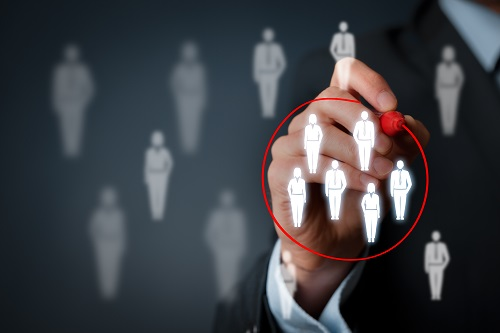
## Background

As a HR manager, you want to understand your employees so that appropriate 
direction can be given to the management to satisfy and retain the employees.

The main goal is to Cluster the different types of Employees based on attributes like their age, job scope,salary etc and answer the following questions. 

* What are the characteristics of each employee cluster
  * Due to these characteristics, what are the main needs of each cluster

*   Which group of employee is the most vulnerable that the management should do 
something to retain them.

*   List item

## Keywords
- Unsupervised Learning
- K-Means Clustering
- Silhouette Analysis
- Hierarchical Clustering
- Spectral Clustering
- Clusters Interpretation

## Import libraries

In [4]:
from typing import Sequence, Tuple
from itertools import combinations, chain
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering,DBSCAN, OPTICS
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import warnings # Statsmodels likes to throw out warnings. Some of them are important, some are not

## EDA
import phik
from phik import resources, report


## Import Dataset

In [5]:
df_raw = pd.read_csv('../Data/Company_Employee.csv')
df_raw

Age  Gender     BusinessTravel            Job Function  \
0      41  Female      Travel_Rarely                   Sales   
1      49    Male  Travel_Frequently  Research & Development   
2      37    Male      Travel_Rarely  Research & Development   
3      33  Female  Travel_Frequently  Research & Development   
4      27    Male      Travel_Rarely  Research & Development   
...   ...     ...                ...                     ...   
1465   36    Male  Travel_Frequently  Research & Development   
1466   39    Male      Travel_Rarely  Research & Development   
1467   27    Male      Travel_Rarely  Research & Development   
1468   49    Male  Travel_Frequently                   Sales   
1469   34    Male      Travel_Rarely  Research & Development   

      Distance Between Company and Home (KM)  \
0                                          1   
1                                          8   
2                                          2   
3                                          3   
4                                          2   
...                                      ...   
1465                                      23   
1466                                       6   
1467                                       4   
1468                                       2   
1469                                       8   

      Education (1 is lowest, 5 is highest)  \
0                                         2   
1                                         1   
2                                         2   
3                                         4   
4                                         1   
...                                     ...   
1465                                      2   
1466                                      1   
1467                                      3   
1468                                      3   
1469                                      3   

      Job Satisfaction (1 is lowest, 4 is highest) MaritalStatus  Salary ($)  \
0                                                4        Single        5993   
1                                                2       Married        5130   
2                                                3        Single        2090   
3                                                3       Married        2909   
4                                                2       Married        3468   
...                                            ...           ...         ...   
1465                                             4       Married        2571   
1466                                             1       Married        9991   
1467                                             2       Married        6142   
1468                                             2       Married        5390   
1469                                             3       Married        4404   

      Performance Rating (1 is lowest, 4 is highest)  \
0                                                  3   
1                                                  4   
2                                                  3   
3                                                  3   
4                                                  3   
...                                              ...   
1465                                               3   
1466                                               3   
1467                                               4   
1468                                               3   
1469                                               3   

      Work Life Balance (1 is worst, 4 is best)  Length of Service (Years)  \
0                                             1                          6   
1                                             3                         10   
2                                             3                          0   
3                                             3                          8   
4                                             3                        

### <h2>Metadata</h2>

| Attribute | Description | Type |
|---|---|---|
| Age | Employee age | Discrete |
| Gender | Employee gender | Categorical-Nominal |
| BusinessTravel:  | Customer's age | Numerical-Continuous |
| Job Function: | Customer's annual income denominated in thousands | Numerical-Continuous |
| Distance Between Company and Home (KM): | spending score between 1 to 100 | Numerical-Continuous |
| Age | Employee age | Discrete |
| Age | Employee age | Discrete |
| Age | Employee age | Discrete |
| Age | Employee age | Discrete |
| Age | Employee age | Discrete |

<link href='styles.css' rel='stylesheet'>
<!--bootstrap-->
<link href="https://cdn.jsdelivr.net/npm/bootstrap@5.0.2/dist/css/bootstrap.min.css" rel="stylesheet" integrity="sha384-EVSTQN3/azprG1Anm3QDgpJLIm9Nao0Yz1ztcQTwFspd3yD65VohhpuuCOmLASjC" crossorigin="anonymous">

## Feature Renaming 

In [6]:
# Remove Explanation in features
df_raw.rename(columns = {
    "Distance Between Company and Home (KM)" : "Distance",
    "Education (1 is lowest, 5 is highest)" : "Education",
    "Job Satisfaction (1 is lowest, 4 is highest)" : "Job_Satisfaction",
    "Salary ($)" : "Salary",
    "Performance Rating (1 is lowest, 4 is highest)" : "Performance_Rating",
    "Work Life Balance (1 is worst, 4 is best)" : "Work_Life_Balance",
    "Length of Service (Years)" : "Service_Years"
}, inplace = True)

In [7]:
df_raw.Gender = df_raw.Gender.astype('category') # Turns Gender to category dtype

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 1470 non-null   int64   
 1   Gender              1470 non-null   category
 2   BusinessTravel      1470 non-null   object  
 3   Job Function        1470 non-null   object  
 4   Distance            1470 non-null   int64   
 5   Education           1470 non-null   int64   
 6   Job_Satisfaction    1470 non-null   int64   
 7   MaritalStatus       1470 non-null   object  
 8   Salary              1470 non-null   int64   
 9   Performance_Rating  1470 non-null   int64   
 10  Work_Life_Balance   1470 non-null   int64   
 11  Service_Years       1470 non-null   int64   
 12  Resign Status       1470 non-null   object  
dtypes: category(1), int64(8), object(4)
memory usage: 139.5+ KB


# EDA

In [8]:
df_eda = df_raw.copy()

In [9]:
df_eda.head()

#Extract all numeric features
df_eda_num = df_eda.select_dtypes(include=['int64', 'float64'])
df_eda_num.columns

Index(['Age', 'Distance', 'Education', 'Job_Satisfaction', 'Salary',
       'Performance_Rating', 'Work_Life_Balance', 'Service_Years'],
      dtype='object')

## Check distribution of all numeric features

Since we are working are going to work with k-means algorithm, that uses elducian distance, we have to check all if features follow what kind of distribution to perform approitate normalization in the Data preprocessing sections

In [10]:
df_eda_num = df_eda.select_dtypes(include=['int64', 'float64'])

numeric_features = df_eda_num.columns
# Extract out number of features
print("Number of features: {}".format(len(numeric_features)))

Number of features: 8


In [11]:
from plotly.subplots import make_subplots

import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go


# Plot distribution of each numerical feature
#Extract all numeric features
df_eda_num = df_eda.select_dtypes(include=['int64', 'float64'])

numeric_features = df_eda_num.columns
print(len(numeric_features))
fig = make_subplots(rows=len(numeric_features), cols=1)
for idx,feature in enumerate(numeric_features):
    fig.append_trace(go.Histogram(x=df_eda_num[feature], name=feature), row=idx+1, col=1)
    # add suptitle
    fig.update_xaxes(title_text=feature, row=idx+1, col=1)
    # Increase height of subplot

fig.update_layout(height=1200, width=800, title_text='Distribution of Numerical Features')
fig.show()



8


Observations:

Conclusions:
Basically say which one gasuaiian (normal) distribution that can just normalize normally, if like skweewd must other method already 


Check whether size follows a power-law, Poisson, or Gaussian distribution.

* Power-law: Log transform and scale to [0,1].
* Poisson: Create quantiles and scale to [0,1].
* Gaussian: Normalize and scale to [0,1].

GO COMPLETE AH OI

## Pairplot

* Is there an identifiable cluster by glancing through the datapoints?
* Is there a significant difference of the Spending Behaviour across different gender?
* Is there a need to remove/create certain features to reduce ambiguity for the clustering?

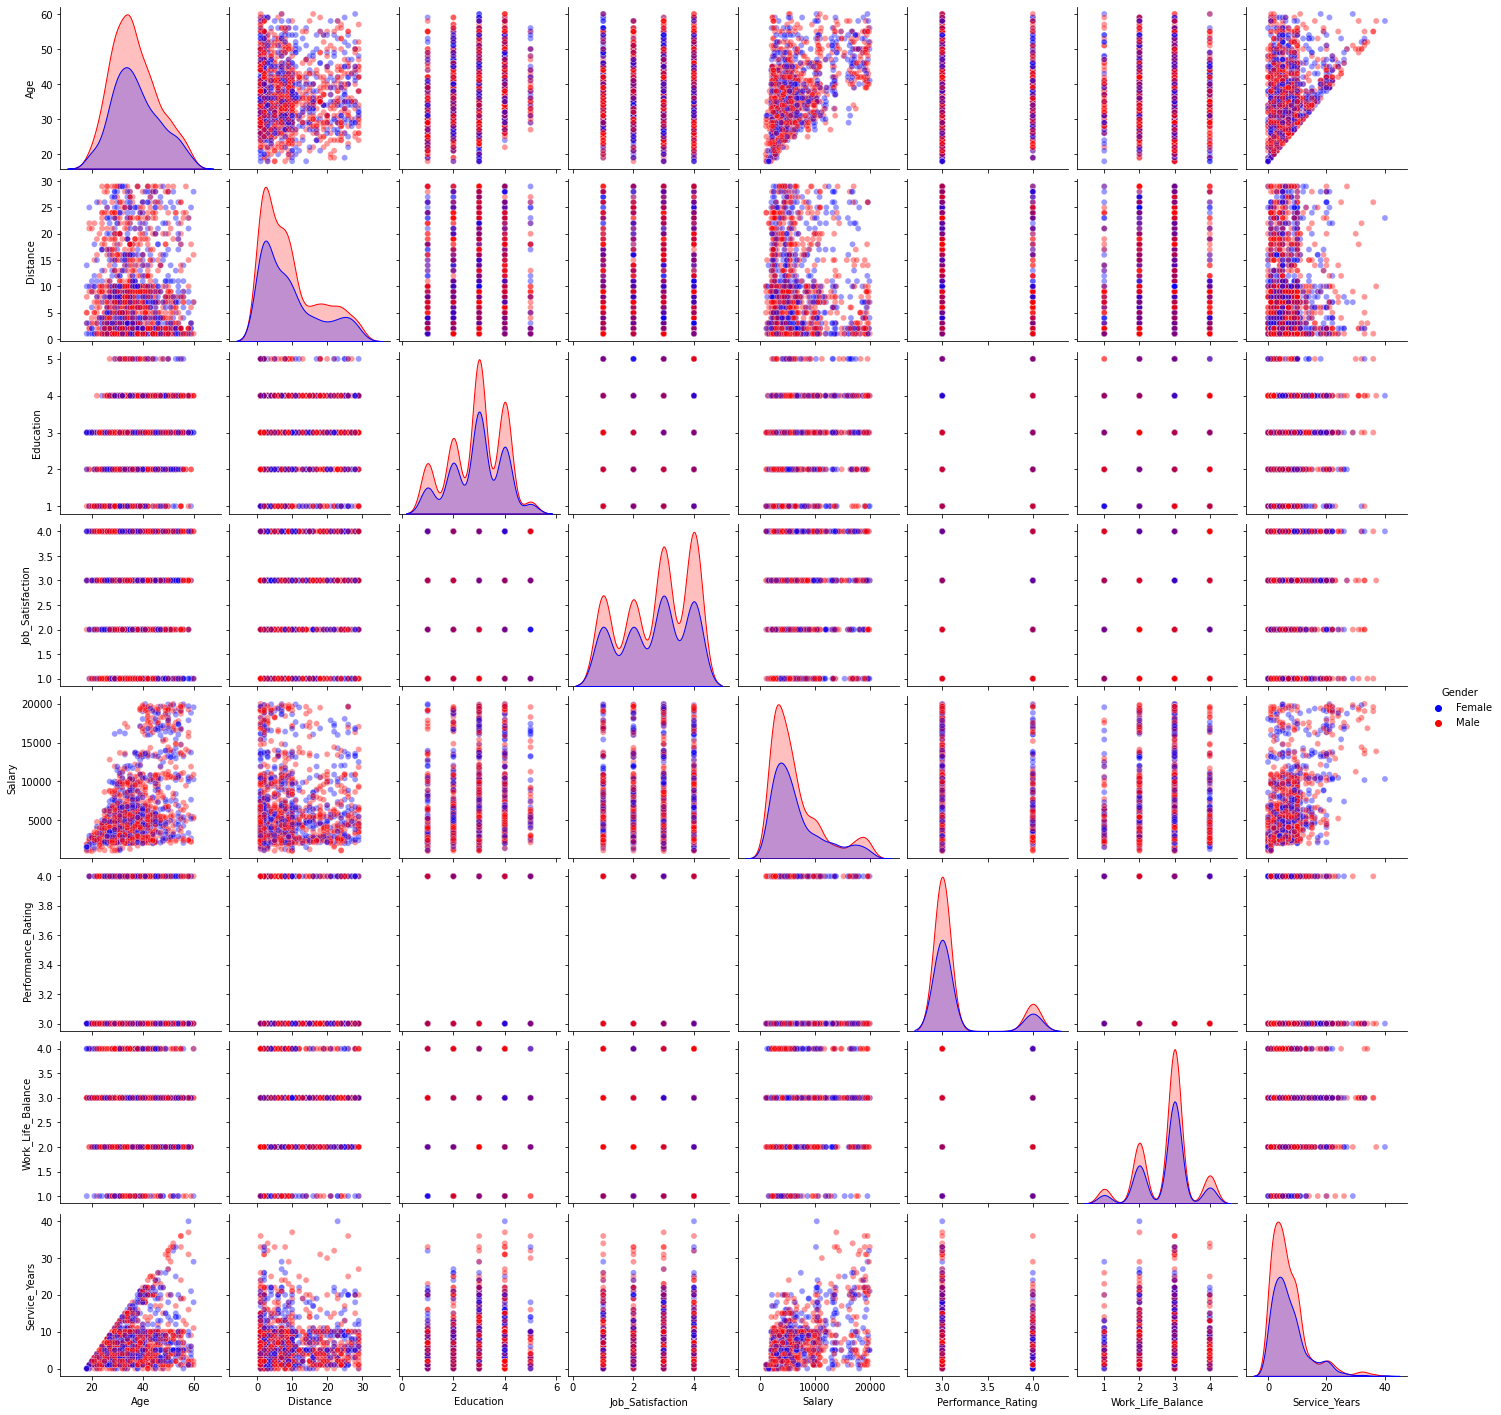

In [12]:
sns.pairplot(df_eda, hue = 'Gender', palette=['b', 'r'], plot_kws=dict(alpha=0.4))
plt.show()

In [13]:
df_eda.phik_matrix()

interval columns not set, guessing: ['Age', 'Distance', 'Education', 'Job_Satisfaction', 'Salary', 'Performance_Rating', 'Work_Life_Balance', 'Service_Years']


Age    Gender  BusinessTravel  Job Function  \
Age                 1.000000  0.000000        0.069800      0.000000   
Gender              0.000000  1.000000        0.022402      0.015435   
BusinessTravel      0.069800  0.022402        1.000000      0.000000   
Job Function        0.000000  0.015435        0.000000      1.000000   
Distance            0.000000  0.034159        0.042961      0.000000   
Education           0.352040  0.000000        0.000000      0.000000   
Job_Satisfaction    0.000000  0.000000        0.000000      0.031204   
MaritalStatus       0.231465  0.019555        0.115345      0.100830   
Salary              0.542212  0.059711        0.043209      0.299377   
Performance_Rating  0.000000  0.000000        0.000000      0.000000   
Work_Life_Balance   0.055496  0.000000        0.000000      0.050038   
Service_Years       0.560431  0.051930        0.000000      0.056353   
Resign Status       0.278172  0.014016        0.074137      0.046641   

                    Distance  Education  Job_Satisfaction  MaritalStatus  \
Age                 0.000000   0.352040          0.000000       0.231465   
Gender              0.034159   0.000000          0.000000       0.019555   
BusinessTravel      0.042961   0.000000          0.000000       0.115345   
Job Function        0.000000   0.000000          0.031204       0.100830   
Distance            1.000000   0.000000          0.000000       0.000000   
Education           0.000000   1.000000          0.018766       0.000000   
Job_Satisfaction    0.000000   0.018766          1.000000       0.000000   
MaritalStatus       0.000000   0.000000          0.000000       1.000000   
Salary              0.108462   0.221059          0.000000       0.101592   
Performance_Rating  0.072127   0.000000          0.039723       0.000000   
Work_Life_Balance   0.000000   0.000000          0.000000       0.000000   
Service_Years       0.000000   0.174985          0.000000       0.095044   
Resign Status       0.089419   0.000000          0.150024       0.104779   

                      Salary  Performance_Rating  Work_Life_Balance  \
Age                 0.542212            0.000000           0.055496   
Gender              0.059711            0.000000           0.000000   
BusinessTravel      0.043209            0.000000           0.000000   
Job Function        0.299377            0.000000           0.050038   
Distance            0.108462            0.072127           0.000000   
Education           0.221059            0.000000           0.000000   
Job_Satisfaction    0.000000            0.039723           0.000000   
MaritalStatus       0.101592            0.000000           0.000000   
Salary              1.000000            0.000000           0.000000   
Performance_Rating  0.000000            1.000000           0.000000   
Work_Life_Balance   0.000000            0.000000           1.000000   
Service_Years       0.610329            0.000000           0.000000   
Resign Status       0.280586            0.000000           0.143809   

                    Service_Years  Resign Status  
Age                      0.560431       0.278172  
Gender                   0.051930       0.014016  
BusinessTravel           0.000000       0.074137  
Job Function             0.056353       0.046641  
Distance                 0.000000       0.089419  
Education                0.174985       0.000000  
Job_Satisfaction         0.000000       0.150024  
MaritalStatus            0.095044       0.104779  
Salary                   0.610329       0.280586  
Performance_Rating       0.000000       0.000000  
Work_Life_Balance        0.000000       0.143809  
Service_Years            1.000000       0.232555  
Resign Status            0.232555       1.000000

interval columns not set, guessing: ['Age', 'Distance', 'Education', 'Job_Satisfaction', 'Salary', 'Performance_Rating', 'Work_Life_Balance', 'Service_Years']


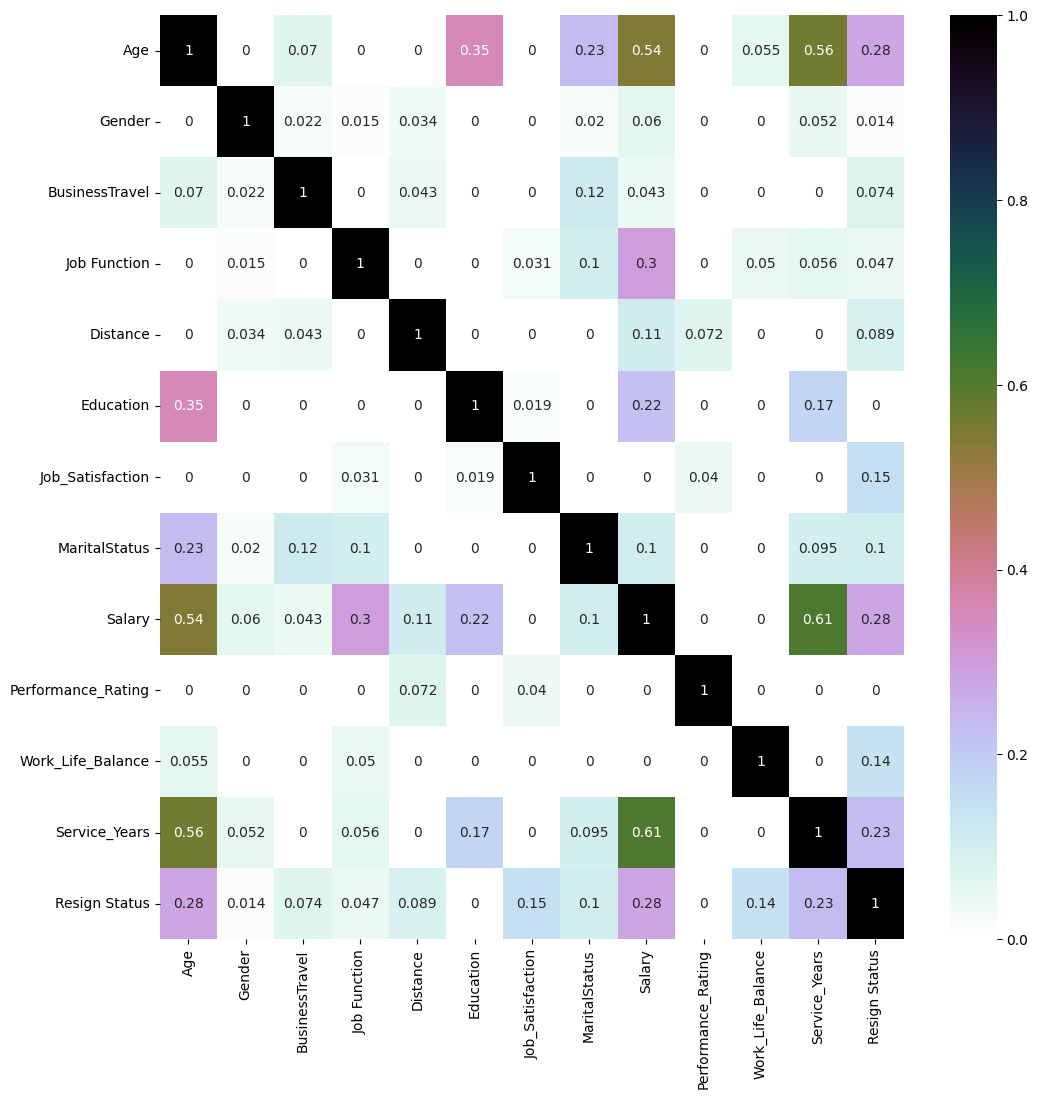

In [14]:
plt.figure(figsize=(12,12))
sns.heatmap(
    df_eda.phik_matrix(),
    cmap="cubehelix_r",
    annot = True)
plt.show()

## Since we are only interested figuring out which clusters of emplyoees 
Focusing of Resign Status, the least correlated features to Resign Status are `Gender`,`Job Function`,`Disatance`, `Education`

## Univaritive Analysis across Resign Status 

In [15]:
df_eda.head()

Age  Gender     BusinessTravel            Job Function  Distance  \
0   41  Female      Travel_Rarely                   Sales         1   
1   49    Male  Travel_Frequently  Research & Development         8   
2   37    Male      Travel_Rarely  Research & Development         2   
3   33  Female  Travel_Frequently  Research & Development         3   
4   27    Male      Travel_Rarely  Research & Development         2   

   Education  Job_Satisfaction MaritalStatus  Salary  Performance_Rating  \
0          2                 4        Single    5993                   3   
1          1                 2       Married    5130                   4   
2          2                 3        Single    2090                   3   
3          4                 3       Married    2909                   3   
4          1                 2       Married    3468                   3   

   Work_Life_Balance  Service_Years Resign Status  
0                  1              6           Yes  
1                  3             10            No  
2                  3              0           Yes  
3                  3              8            No  
4                  3              2            No

In [16]:
df_eda.columns

Index(['Age', 'Gender', 'BusinessTravel', 'Job Function', 'Distance',
       'Education', 'Job_Satisfaction', 'MaritalStatus', 'Salary',
       'Performance_Rating', 'Work_Life_Balance', 'Service_Years',
       'Resign Status'],
      dtype='object')

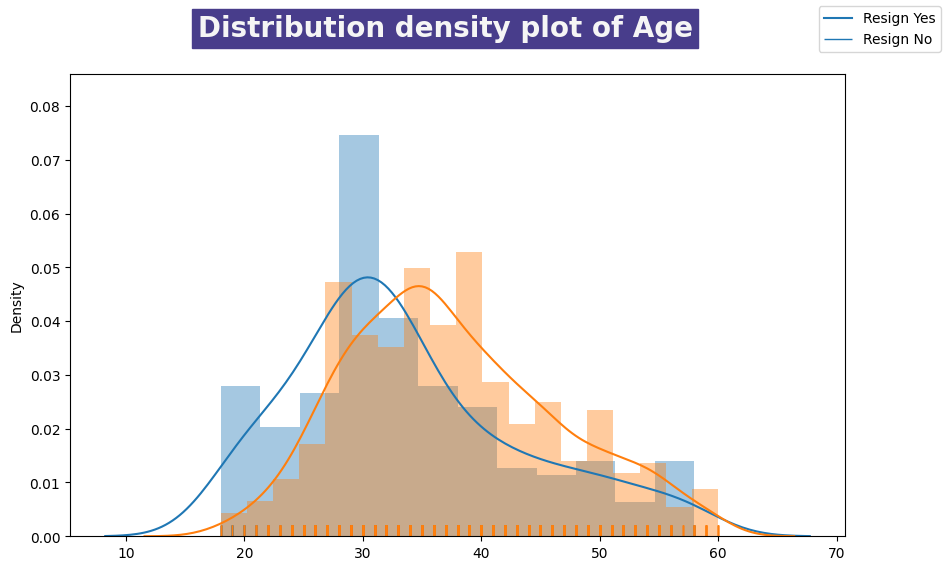

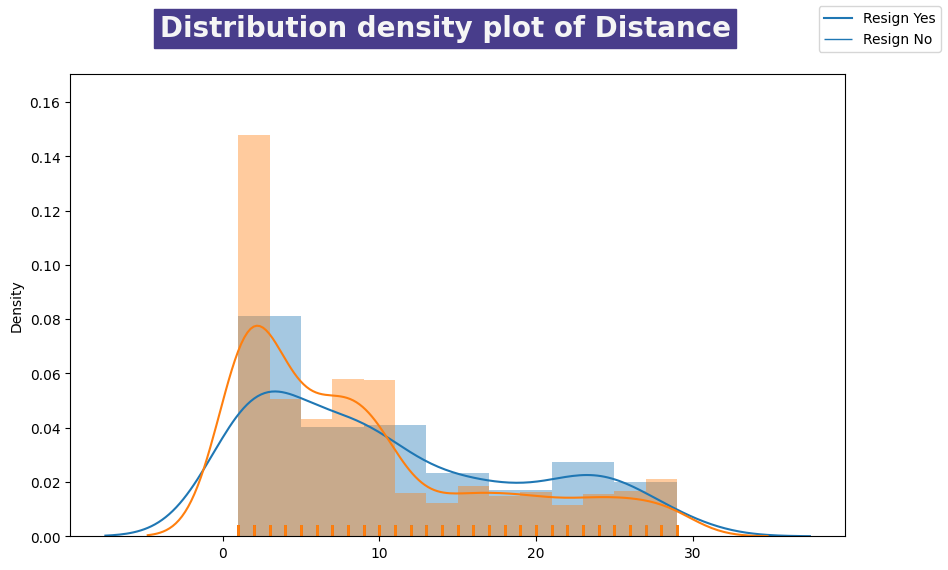

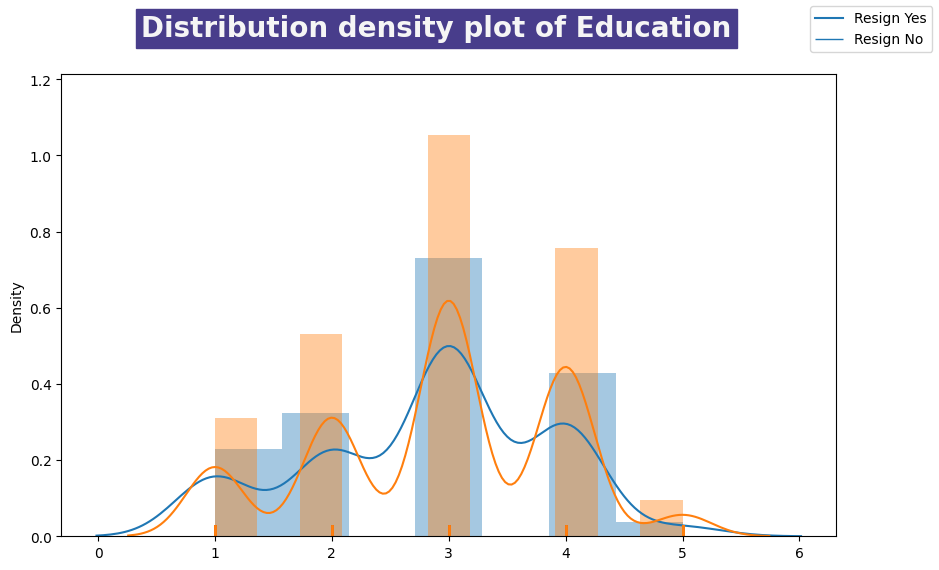

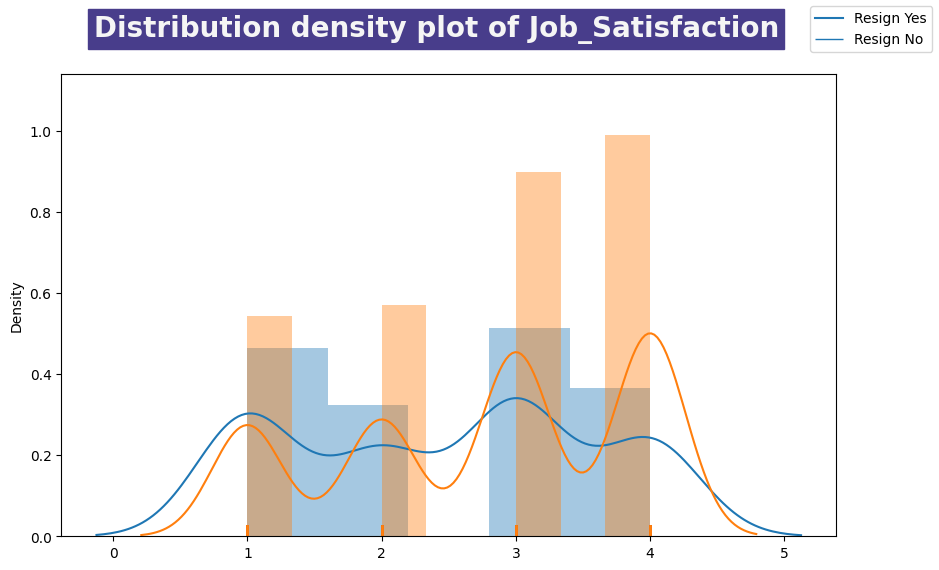

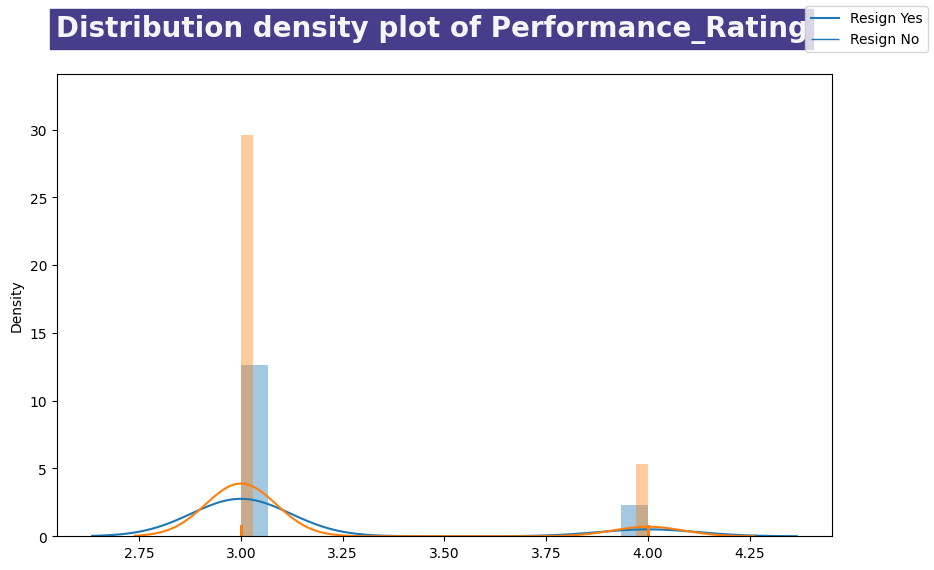

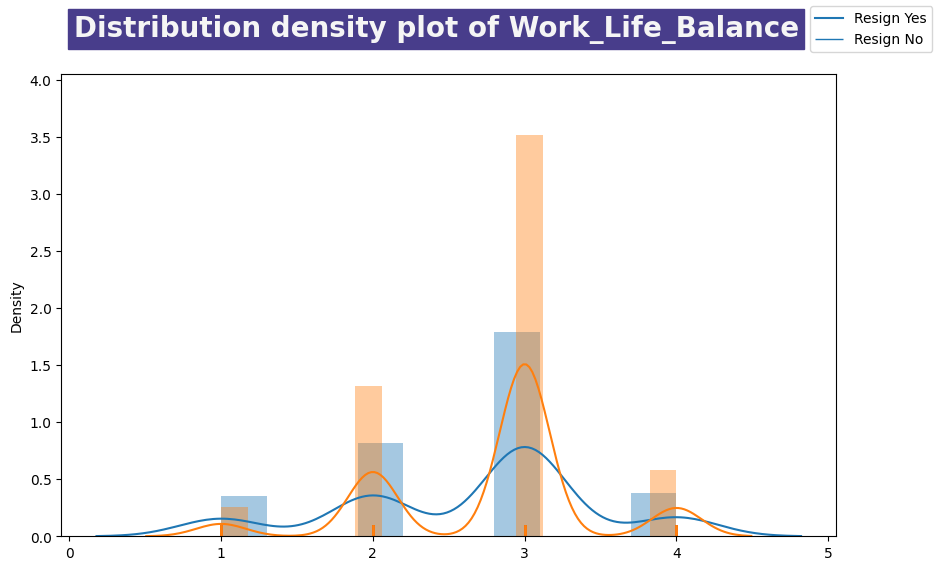

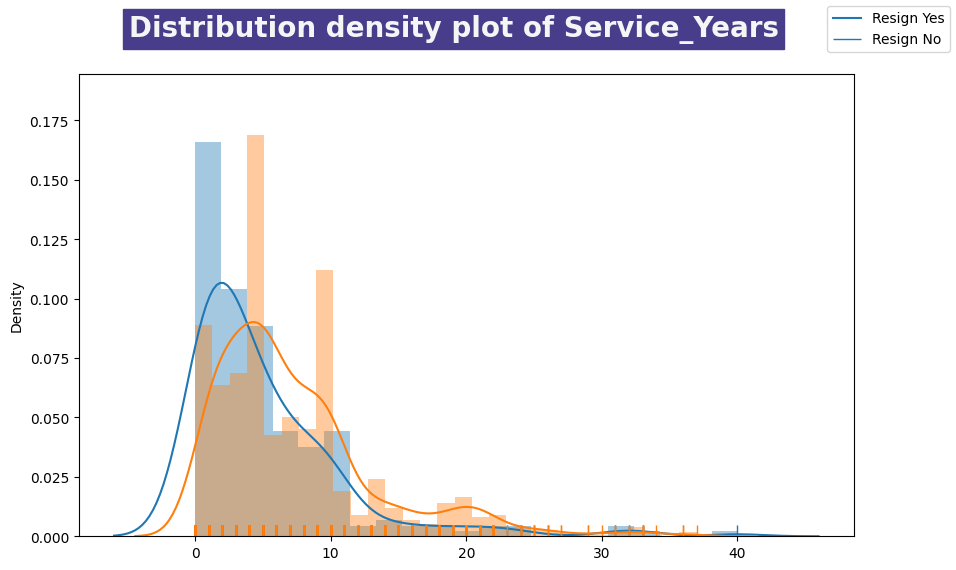

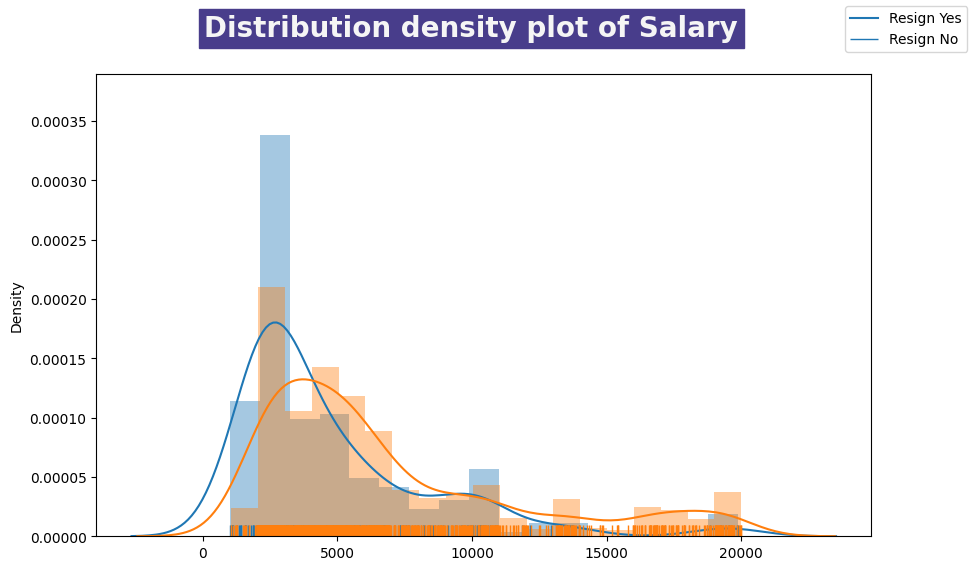

In [37]:
df_eda_resign = df_eda[df_eda['Resign Status']=='Yes']
df_eda_normal = df_eda[df_eda['Resign Status']=='No']

# df_eda_melt = df_eda.melt(['Machine Status'],value_vars=['Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)','Torque (Nm)'], var_name='cols',  value_name='vals')

features = ['Age','Distance','Education', 'Job_Satisfaction','Performance_Rating', 'Work_Life_Balance', 'Service_Years', 'Salary']	

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in features:
      fig = plt.figure(figsize=(10,6))
      sns.distplot(df_eda_resign[[i]], hist=True, rug=True)
      sns.distplot(df_eda_normal[[i]], hist=True, rug=True)

      fig.suptitle(f'Distribution density plot of {i}',color='whitesmoke',weight='bold',size=20, backgroundcolor= 'darkslateblue')

      fig.legend(labels=['Resign Yes','Resign No'])
      plt.show()

Observations:

* Age follows a gaussian distribution
* Service Year seems to be very positively skewed
* 

# Data Preprocessing

* Transform 
* Scale features to [0-1] min max scalar
* Ordinal Encode `BusinessTravel`
* One-Hot-Encode the rest of categorical features

In [18]:
# Extract all numeric values
numeric = df_raw.select_dtypes(include=np.number).columns.tolist()
numeric

['Age',
 'Distance',
 'Education',
 'Job_Satisfaction',
 'Salary',
 'Performance_Rating',
 'Work_Life_Balance',
 'Service_Years']

## Standard Scaling

In [19]:
scaler = StandardScaler()
df_scaled = df_raw.copy()
df_scaled[numeric] = scaler.fit_transform(df_scaled[numeric])
df_scaled.head()

Age  Gender     BusinessTravel            Job Function  Distance  \
0  0.446350  Female      Travel_Rarely                   Sales -1.010909   
1  1.322365    Male  Travel_Frequently  Research & Development -0.147150   
2  0.008343    Male      Travel_Rarely  Research & Development -0.887515   
3 -0.429664  Female  Travel_Frequently  Research & Development -0.764121   
4 -1.086676    Male      Travel_Rarely  Research & Development -0.887515   

   Education  Job_Satisfaction MaritalStatus    Salary  Performance_Rating  \
0  -0.891688          1.153254        Single -0.108350           -0.426230   
1  -1.868426         -0.660853       Married -0.291719            2.346151   
2  -0.891688          0.246200        Single -0.937654           -0.426230   
3   1.061787          0.246200       Married -0.763634           -0.426230   
4  -1.868426         -0.660853       Married -0.644858           -0.426230   

   Work_Life_Balance  Service_Years Resign Status  
0          -2.493820      -0.164613           Yes  
1           0.338096       0.488508            No  
2           0.338096      -1.144294           Yes  
3           0.338096       0.161947            No  
4           0.338096      -0.817734            No

## Testing removal of columns



## One-Hot-Encoding

In [20]:
df_onehot = pd.get_dummies(df_scaled, drop_first=True)
df_onehot.head()

Age  Distance  Education  Job_Satisfaction    Salary  \
0  0.446350 -1.010909  -0.891688          1.153254 -0.108350   
1  1.322365 -0.147150  -1.868426         -0.660853 -0.291719   
2  0.008343 -0.887515  -0.891688          0.246200 -0.937654   
3 -0.429664 -0.764121   1.061787          0.246200 -0.763634   
4 -1.086676 -0.887515  -1.868426         -0.660853 -0.644858   

   Performance_Rating  Work_Life_Balance  Service_Years  Gender_Male  \
0           -0.426230          -2.493820      -0.164613            0   
1            2.346151           0.338096       0.488508            1   
2           -0.426230           0.338096      -1.144294            1   
3           -0.426230           0.338096       0.161947            0   
4           -0.426230           0.338096      -0.817734            1   

   BusinessTravel_Travel_Frequently  BusinessTravel_Travel_Rarely  \
0                                 0                             1   
1                                 1                             0   
2                                 0                             1   
3                                 1                             0   
4                                 0                             1   

   Job Function_Research & Development  Job Function_Sales  \
0                                    0                   1   
1                                    1                   0   
2                                    1                   0   
3                                    1                   0   
4                                    1                   0   

   MaritalStatus_Married  MaritalStatus_Single  Resign Status_Yes  
0                      0                     1                  1  
1                      1                     0                  0  
2                      0                     1                  1  
3                      1                     0                  0  
4                      1                     0                  0

In [21]:
df_onehot.columns

Index(['Age', 'Distance', 'Education', 'Job_Satisfaction', 'Salary',
       'Performance_Rating', 'Work_Life_Balance', 'Service_Years',
       'Gender_Male', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Job Function_Research & Development',
       'Job Function_Sales', 'MaritalStatus_Married', 'MaritalStatus_Single',
       'Resign Status_Yes'],
      dtype='object')

## Feature extractions ( TESTING JUST REMOVING SHIT)

In [22]:
df_onehot = df_onehot.drop(columns=['Gender_Male','Job Function_Research & Development','Job Function_Sales', "Education",'Performance_Rating'])
df_onehot.head()

Age  Distance  Job_Satisfaction    Salary  Work_Life_Balance  \
0  0.446350 -1.010909          1.153254 -0.108350          -2.493820   
1  1.322365 -0.147150         -0.660853 -0.291719           0.338096   
2  0.008343 -0.887515          0.246200 -0.937654           0.338096   
3 -0.429664 -0.764121          0.246200 -0.763634           0.338096   
4 -1.086676 -0.887515         -0.660853 -0.644858           0.338096   

   Service_Years  BusinessTravel_Travel_Frequently  \
0      -0.164613                                 0   
1       0.488508                                 1   
2      -1.144294                                 0   
3       0.161947                                 1   
4      -0.817734                                 0   

   BusinessTravel_Travel_Rarely  MaritalStatus_Married  MaritalStatus_Single  \
0                             1                      0                     1   
1                             0                      1                     0   
2                             1                      0                     1   
3                             0                      1                     0   
4                             1                      1                     0   

   Resign Status_Yes  
0                  1  
1                  0  
2                  1  
3                  0  
4                  0

# Clustering

In [23]:
def calculate_k_mean(n_cluster: int, X: Sequence)-> Tuple[float, Sequence, Sequence, sklearn.cluster._kmeans.KMeans]:
    '''
    General Function to returns commonly used metrics for K-Means Clustering and the fitted instance
    '''
    kmean = KMeans(n_clusters = n_cluster, random_state=24)
    cluster_labels = kmean.fit_predict(X)
    print(cluster_labels)
    return kmean.inertia_, cluster_labels, kmean.cluster_centers_, kmean

In [24]:
log = [] 
silhoettes = True
k_range = range(2,9) # Range of k values

for k in k_range:
    inertia, cluster_labels, _, _ = calculate_k_mean(k, df_onehot) # Fitting the model
    if silhoettes: # Generate Silhoettes Score
        silhoettes_avg = silhouette_score(df_onehot, cluster_labels)
        log.append([k, inertia, silhoettes_avg])
        continue
    log.append([k, inertia])

[0 0 0 ... 0 0 0]
[2 0 2 ... 0 0 2]
[2 3 2 ... 3 3 2]
[2 3 1 ... 3 2 1]
[0 2 5 ... 2 0 5]
[5 4 0 ... 4 3 0]
[4 3 7 ... 1 3 7]


In [25]:
kmean = KMeans(n_clusters = 3, random_state=24)
cluster_labels = kmean.fit_predict(df_onehot)
display(kmean.feature_names_in_)

array(['Age', 'Distance', 'Job_Satisfaction', 'Salary',
       'Work_Life_Balance', 'Service_Years',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'MaritalStatus_Married', 'MaritalStatus_Single',
       'Resign Status_Yes'], dtype=object)

## Elbow Method ( Inertia )

To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the inertia start decreasing in a linear fashion.

$$ \text{Inertia} = \sum^m_{i=1}||x^{(i)}-\mu_{c^{(i)}}||^2_2 $$

- $m$ : Number of Datapoints
- $x^{(i)}$ : i-th Datapoints
- $\mu_{c^{(i)}}$ : Cluster Centroids for i-th Datapoints

> Inertia Measure the Sum of Squared Distance of each datapoints to its assigned cluster centroids.

However, I personally do not believe that using our human intuition to "Eyeball" where the elbow is to be optimal. Hence I'll be using Kneed package to compute the optimal elbow directly


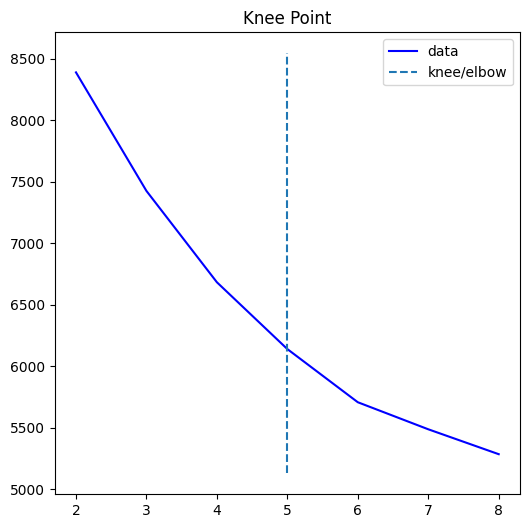

In [26]:
from kneed import KneeLocator
plot_df = pd.DataFrame(
    log, columns = [
        'k', 'Inertias (Sum of squared distances to Nearest Cluster Centroids)', 'Silhouette Coefficient'
        ]
    )
kl = KneeLocator(plot_df['k'], plot_df['Inertias (Sum of squared distances to Nearest Cluster Centroids)'], curve="convex",direction="decreasing")
kl.plot_knee()

Observations:


[2 0 2 ... 0 0 2]


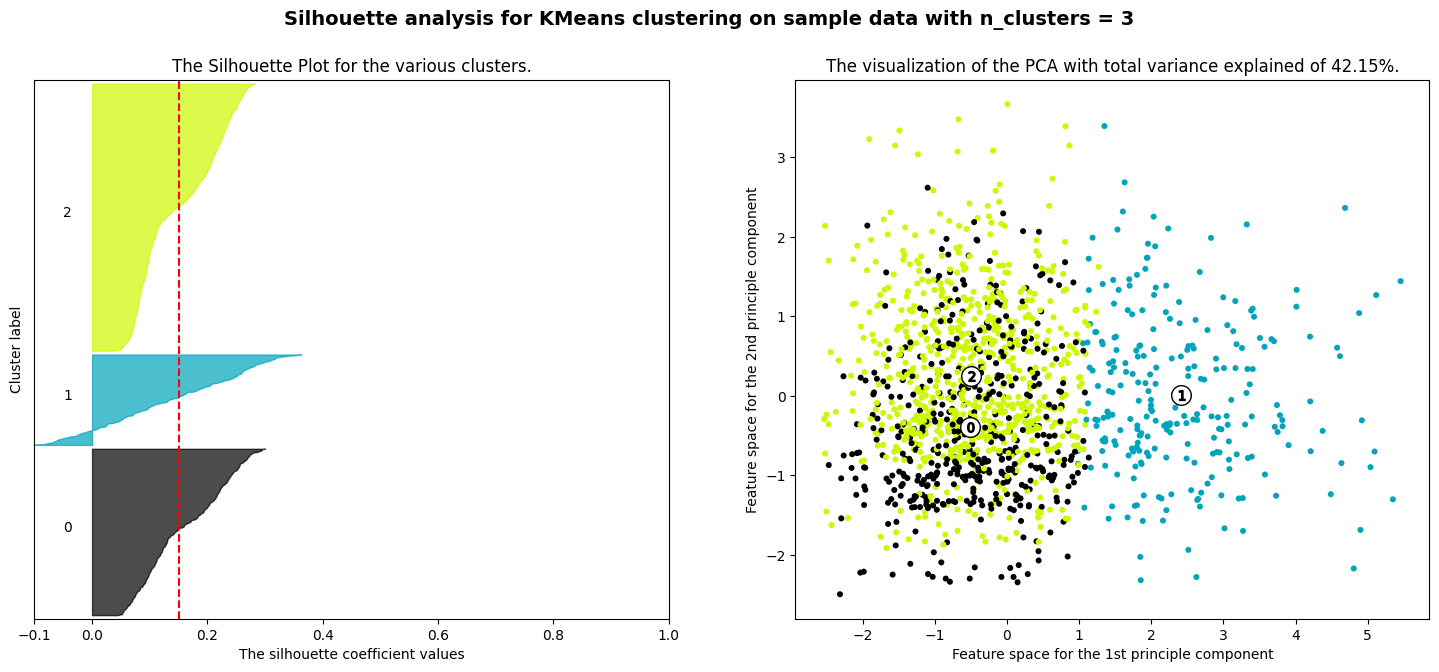

[2 3 2 ... 3 3 2]


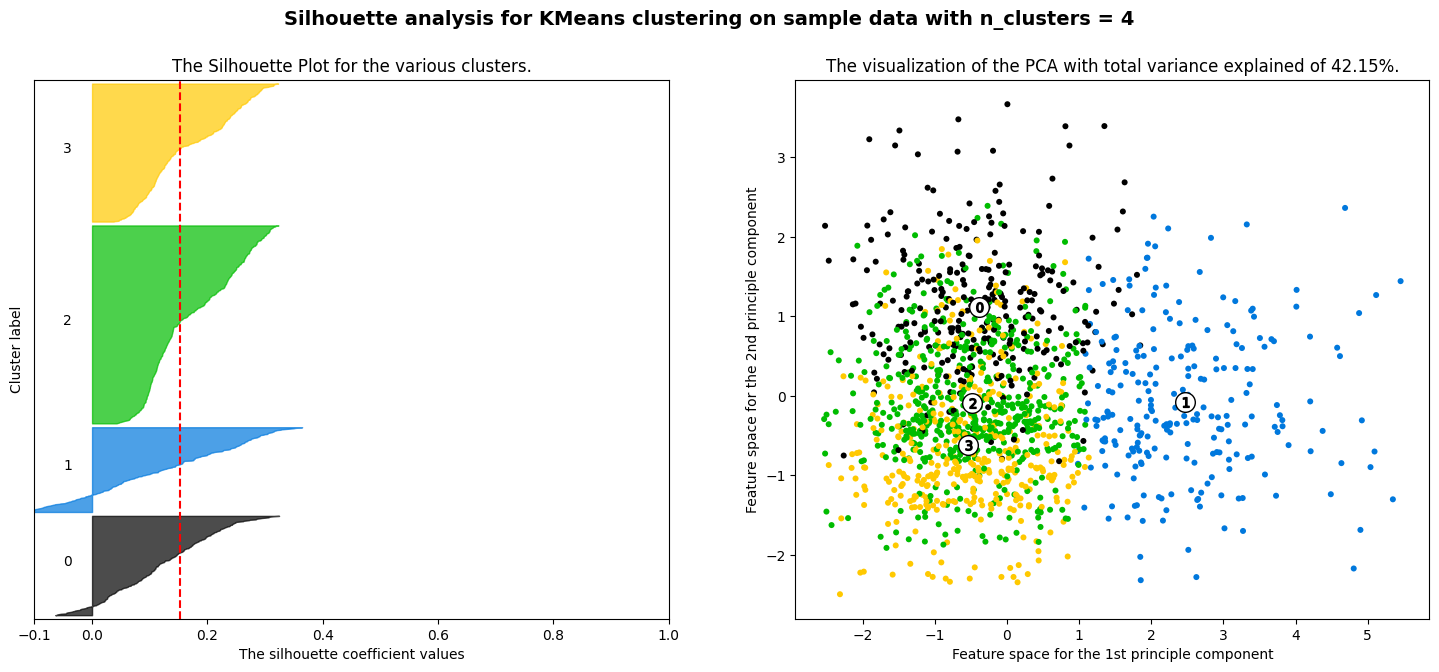

[2 3 1 ... 3 2 1]


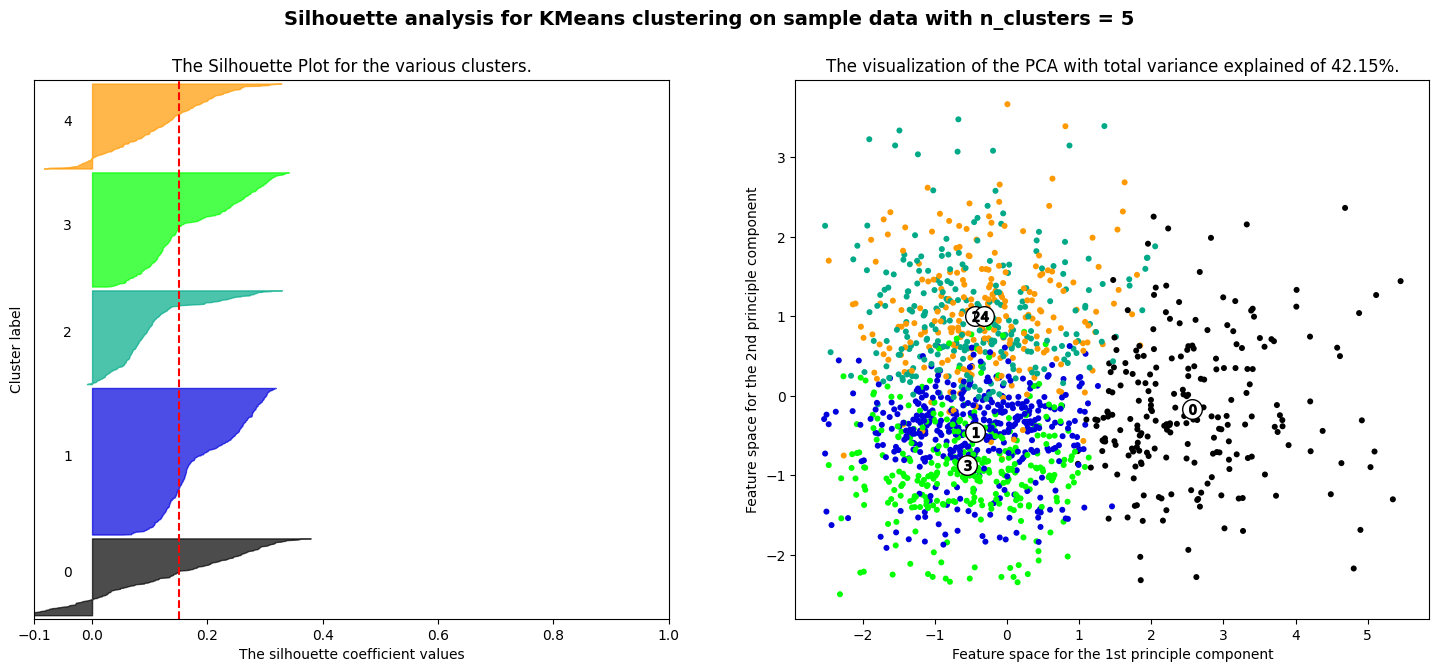

[0 2 5 ... 2 0 5]


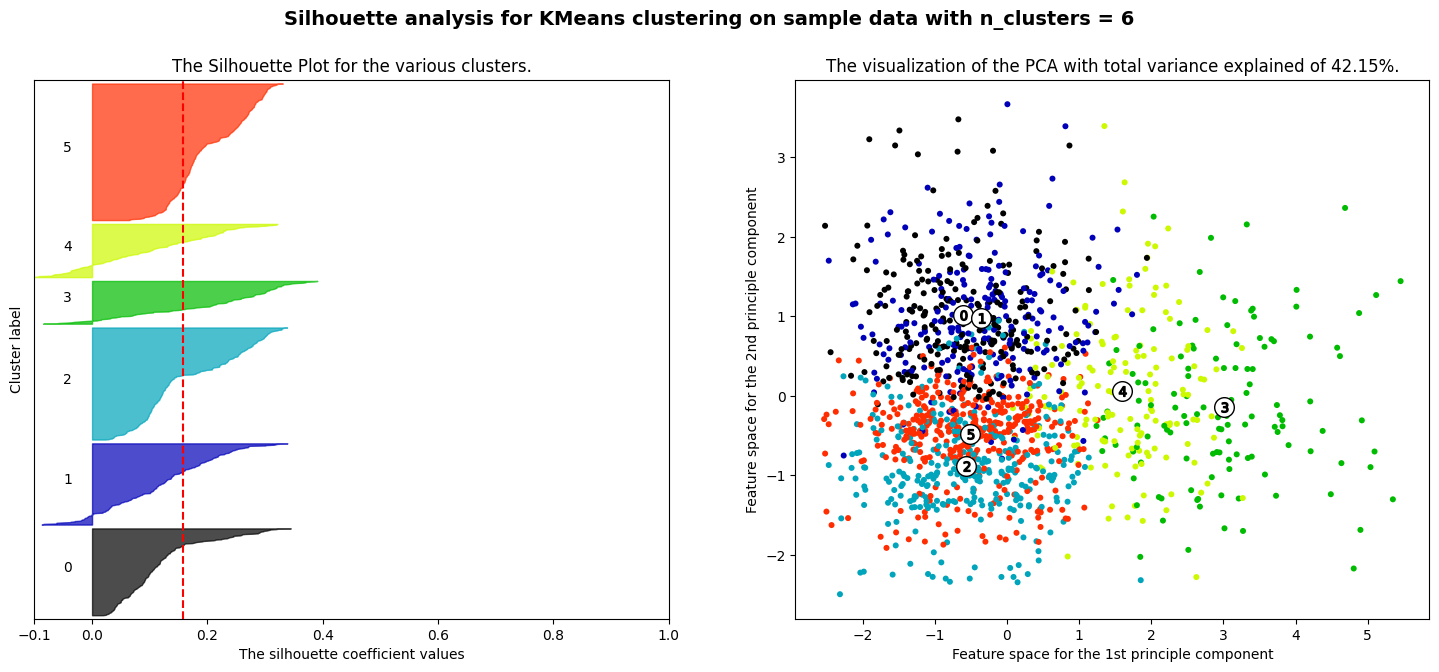

[5 4 0 ... 4 3 0]


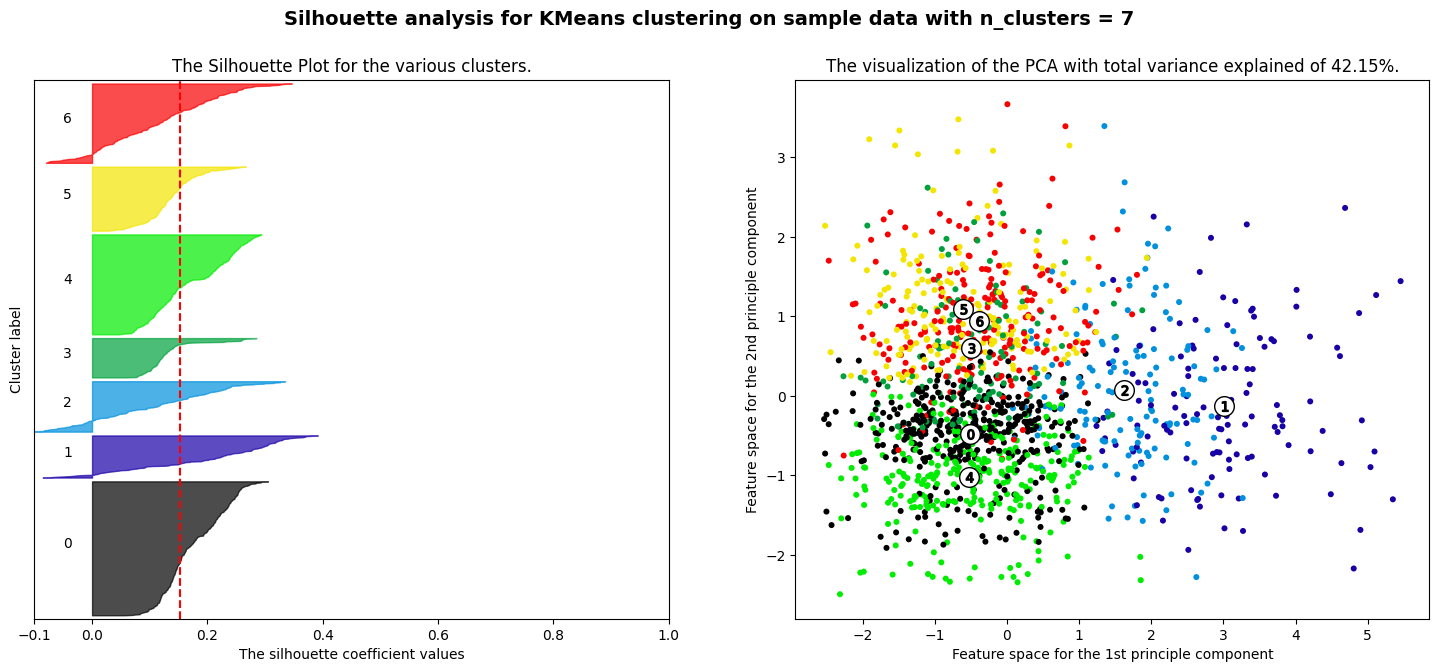

[4 3 7 ... 1 3 7]


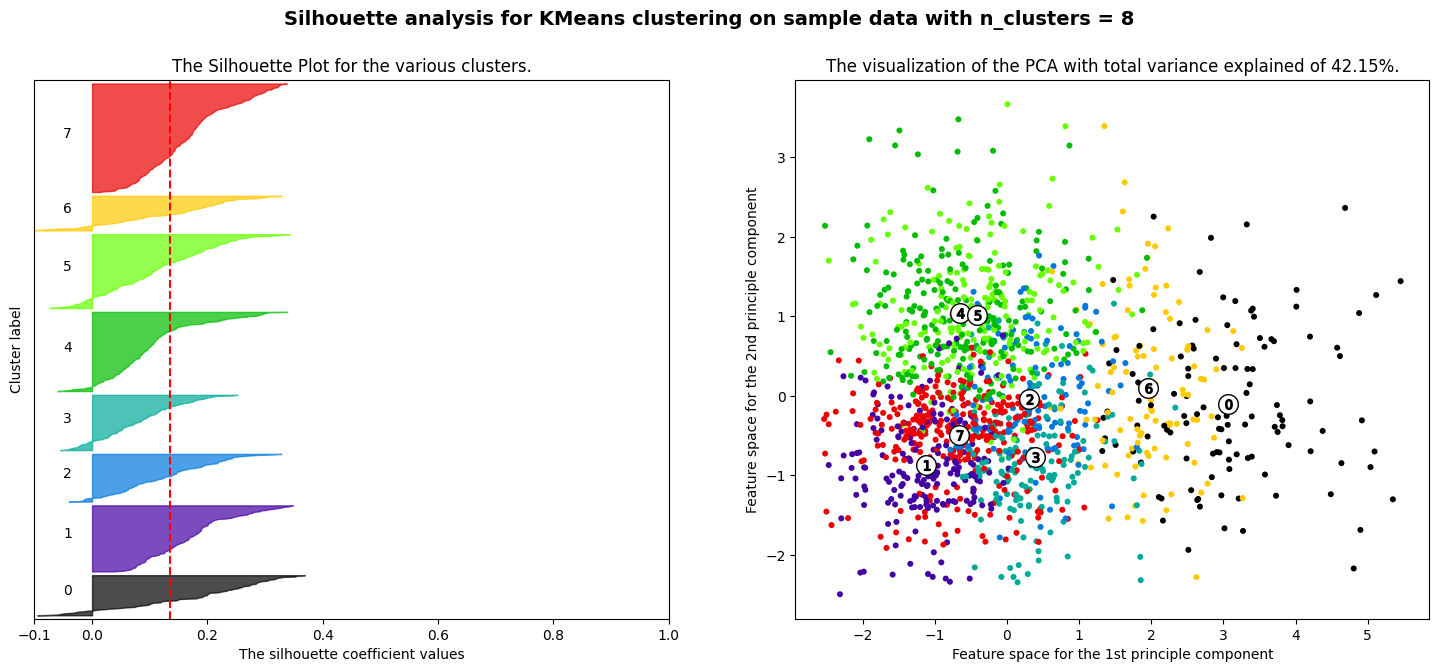

In [27]:
def silhouette_analysis_with_pca(n_clusters : int,  X: Sequence):
    '''
    Perform Silhoette Analysis and Visualising the clusters generated using PCA

    Reference: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    '''
    
    # Perform K-Mean Clustering
    _, cluster_labels, cluster_centroids, kmean = calculate_k_mean(n_clusters, X)

    # Compute Individual Silhoette Score
    silhoettes_avg = silhouette_score(X, cluster_labels)

    # Compute Average Silhoette Score
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ################################### Silhouette Plot #############################################
  
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(df_raw) + (n_clusters + 1) * 10])
    y_lower = 10

    # Assign colours for different cluster
    for i in range(n_clusters):
         # Aggregate the silhouette scores for samples belonging to
         # cluster i, and sort them
         ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
         ith_cluster_silhouette_values.sort()
         size_cluster_i = ith_cluster_silhouette_values.shape[0]
         y_upper = y_lower + size_cluster_i
         color = cm.nipy_spectral(float(i) / n_clusters)
         ax1.fill_betweenx(np.arange(y_lower, y_upper),
                           0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.7)
         # Label the silhouette plots with their cluster numbers at the middle
         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
         # Compute the new y_lower for next plot
         y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The Silhouette Plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhoettes_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    ################################### PCA Plot #############################################
 
    # Compute PCA with only First 2 Number of Component
    pca2 = PCA(n_components=2)
    sample_pca2 = pca2.fit_transform(X)

    # Plotting the PCA graph
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(sample_pca2[:,0], sample_pca2[:,1], marker='.', s=75, lw=0, alpha=1,
            c=colors, edgecolor='k')

    # Labeling the clusters
    centers = cluster_centroids.dot(pca2.components_.T) # Calculate New Cluster Positions after PCA

    # Labelling each cluster centroids
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                 c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the PCA with total variance explained of {:.2f}%.".format(pca2.explained_variance_ratio_.sum()*100))
    ax2.set_xlabel("Feature space for the 1st principle component")
    ax2.set_ylabel("Feature space for the 2nd principle component")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

for i, k in enumerate(range(3,9)): # Analyse k = (4,5,6)
    silhouette_analysis_with_pca(n_clusters = k, X = df_onehot)
    plt.show()

## PCA analysis

In [28]:
df_onehot.columns

Index(['Age', 'Distance', 'Job_Satisfaction', 'Salary', 'Work_Life_Balance',
       'Service_Years', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'Resign Status_Yes'],
      dtype='object')

In [29]:
df_onehot

Age  Distance  Job_Satisfaction    Salary  Work_Life_Balance  \
0     0.446350 -1.010909          1.153254 -0.108350          -2.493820   
1     1.322365 -0.147150         -0.660853 -0.291719           0.338096   
2     0.008343 -0.887515          0.246200 -0.937654           0.338096   
3    -0.429664 -0.764121          0.246200 -0.763634           0.338096   
4    -1.086676 -0.887515         -0.660853 -0.644858           0.338096   
...        ...       ...               ...       ...                ...   
1465 -0.101159  1.703764          1.153254 -0.835451           0.338096   
1466  0.227347 -0.393938         -1.567907  0.741140           0.338096   
1467 -1.086676 -0.640727         -0.660853 -0.076690           0.338096   
1468  1.322365 -0.887515         -0.660853 -0.236474          -1.077862   
1469 -0.320163 -0.147150          0.246200 -0.445978           1.754054   

      Service_Years  BusinessTravel_Travel_Frequently  \
0         -0.164613                                 0   
1          0.488508                                 1   
2         -1.144294                                 0   
3          0.161947                                 1   
4         -0.817734                                 0   
...             ...                               ...   
1465      -0.327893                                 1   
1466      -0.001333                                 0   
1467      -0.164613                                 0   
1468       0.325228                                 1   
1469      -0.491174                                 0   

      BusinessTravel_Travel_Rarely  MaritalStatus_Married  \
0                                1                      0   
1                                0                      1   
2                                1                      0   
3                                0                      1   
4                                1                      1   
...                            ...                    ...   
1465                             0                      1   
1466                             1                      1   
1467                             1                      1   
1468                             0                      1   
1469                             1                      1   

      MaritalStatus_Single  Resign Status_Yes  
0                        1                  1  
1                        0                  0  
2                        1                  1  
3                        0                  0  
4                        0                  0  
...                    ...                ...  
1465                     0                  0  
1466                     0                  0  
1467                     0                  0  
1468                     0                  0  
1469                     0                  0  

[1470 rows x 11 columns]

In [30]:
from sklearn.decomposition import PCA

columns_PCA = ['Age', 'Distance', 'Education', 'Job_Satisfaction', 'Salary',
       'Performance_Rating', 'Work_Life_Balance', 'Service_Years',
       'Gender_Male', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Job Function_Research & Development',
       'Job Function_Sales', 'MaritalStatus_Married', 'MaritalStatus_Single',
       'Resign Status_Yes']

pca = PCA(n_components=16).fit(df_onehot[columns_PCA])

def pca_results(data, pca):
    
    # Dimension indexing
    dimensions = ['PC {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = columns_PCA) 
    components.index = dimensions

    #PCA eigenvalues
    ev = pca.explained_variance_.reshape(len(pca.components_), 1)
    eigenvalues = pd.DataFrame(np.round(ev, 4), columns = ['Eigenvalue']) 
    eigenvalues.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    #PCA cumulative variance explained
    cum_ratios = pca.explained_variance_ratio_.cumsum().reshape(len(pca.components_), 1)
    cum_variance_ratios = pd.DataFrame(np.round(cum_ratios, 4), columns = ['Cumulative Explained Variance'])
    cum_variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([eigenvalues, variance_ratios,cum_variance_ratios, components], axis = 1)

KeyError: "['Education', 'Performance_Rating', 'Gender_Male', 'Job Function_Research & Development', 'Job Function_Sales'] not in index"

In [ ]:
pca_df = pca_results(df_onehot,pca)
pca_df

In [ ]:
#Scree plot
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

plt.clf()
fig1, ax1 = plt.subplots()
ax1.plot(np.arange(1, len(pca.explained_variance_)+1), pca.explained_variance_)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set(xlabel = 'Component number', ylabel = 'Eigenvalue', title = 'Screeplot')
plt.show()

# K means Clustering 

K means Clustering is by far the most popular algorithm for clustering data by assign clusters based on the distance towards the cluster centroids iterative. This is due to easy to implement and understand

I will be choosing to set parameters such that the initialization method to be 'k-means++' which will initialize starting centroids very far away from data points which reduces the initialization sensitivity that would affect the final formed clusters. 

In [ ]:
display(df_onehot)

In [ ]:
def cluster_results(data):
    cluster_centers = data.groupby('Cluster').mean()
    cluster_centers['Cluster Size (% of Total)'] = pd.Series(data['Cluster']).value_counts() / len(data['Cluster']) * 100
    cluster_centers['Cardinality'] = pd.Series(data['Cluster']).value_counts()
    #Cluster magnitude is the sum of distances from all examples to the centroid of the cluster
    return cluster_centers

In [ ]:
def plot_tsne_clusters(data,cluster,tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=35)):
    tsne_data = tsne.fit_transform(data)
    plt.figure(figsize=(16,10))
    sns.scatterplot(
    x=tsne_data[:,0], y=tsne_data[:,1],
    hue=cluster,
    data=tsne_data,
    legend="full",
    alpha=0.7)
    plt.show()

Age  Distance  Job_Satisfaction    Salary  Work_Life_Balance  \
Cluster                                                                      
0        0.923596 -0.062830         -0.124180  1.837243           0.102103   
1       -0.584116 -0.442306          0.722123 -0.350119           0.600311   
2       -0.228739  1.767207          0.100729 -0.291699           0.131046   
3        1.303887 -0.304477          0.325567 -0.212768           0.267298   
4       -0.288307 -0.156124         -1.130872 -0.410384          -1.476905   
5        1.459519 -0.078597          0.081281  2.061399          -0.176798   
6       -0.443430 -0.247275          0.790432 -0.393665          -1.369145   
7       -0.432909 -0.395766         -1.164772 -0.374787           0.526891   

         Service_Years  BusinessTravel_Travel_Frequently  \
Cluster                                                    
0             2.494133                          0.191667   
1            -0.207953                          0.206790   
2            -0.174626                          0.216981   
3            -0.187064                          0.181250   
4            -0.200238                          0.190909   
5            -0.232234                          0.151515   
6            -0.243921                          0.177143   
7            -0.286166                          0.166667   

         BusinessTravel_Travel_Rarely  MaritalStatus_Married  \
Cluster                                                        
0                            0.725000               0.508333   
1                            0.682099               0.407407   
2                            0.641509               0.495283   
3                            0.750000               0.487500   
4                            0.727273               0.454545   
5                            0.767677               0.535354   
6                            0.691429               0.434286   
7                            0.748148               0.437037   

         MaritalStatus_Single  Resign Status_Yes  Cluster Size (% of Total)  \
Cluster                                                                       
0                    0.225000           0.091667                   8.163265   
1                    0.373457           0.123457                  22.040816   
2                    0.301887           0.226415                  14.421769   
3                    0.293750           0.131250                  10.884354   
4                    0.300000           0.200000                   7.482993   
5                    0.262626           0.030303                   6.734694   
6                    0.348571           0.217143                  11.904762   
7                    0.337037           0.200000                  18.367347   

         Cardinality  
Cluster               
0                120  
1                324  
2                212  
3                160  
4                110  
5                 99  
6                175  
7                270

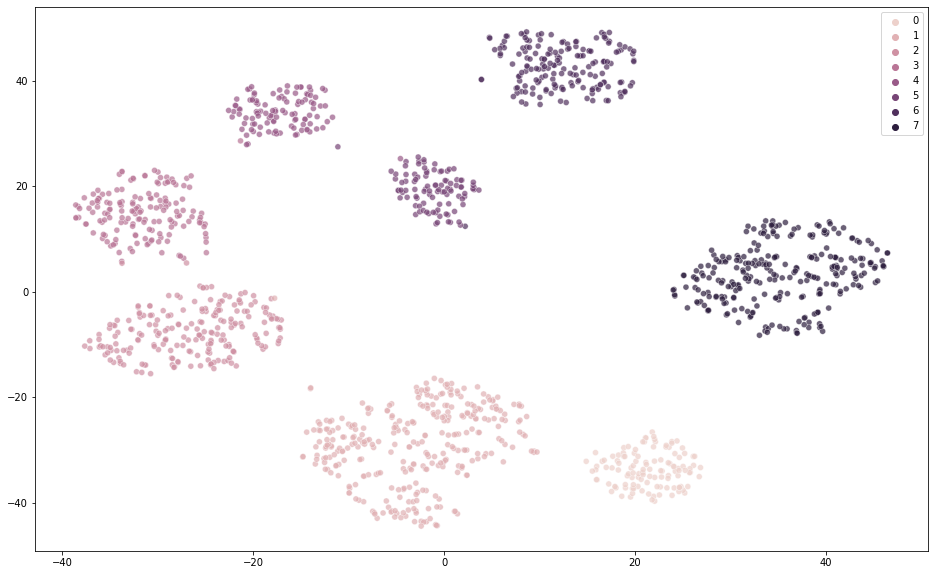

In [ ]:
kmean_df = df_onehot.copy()
kmean =  KMeans(init='k-means++', max_iter=500, algorithm = "elkan", random_state=0).fit(df_onehot)

cluster_labels = kmean.predict(df_onehot)
kmean_df['Cluster'] = cluster_labels
cluster_center_results = cluster_results(kmean_df)
display(cluster_center_results)

plot_tsne_clusters(kmean_df,cluster_labels)

In [ ]:
display(cluster_labels)

array([6, 3, 1, ..., 7, 3, 1])

array([[ 26.802475 ,  35.00853  ],
       [-26.273582 ,  14.828896 ],
       [-12.726168 , -29.5661   ],
       ...,
       [ 32.85343  ,   2.0861237],
       [-15.58225  ,  34.858055 ],
       [ -8.487036 , -38.99266  ]], dtype=float32)

<AxesSubplot:>

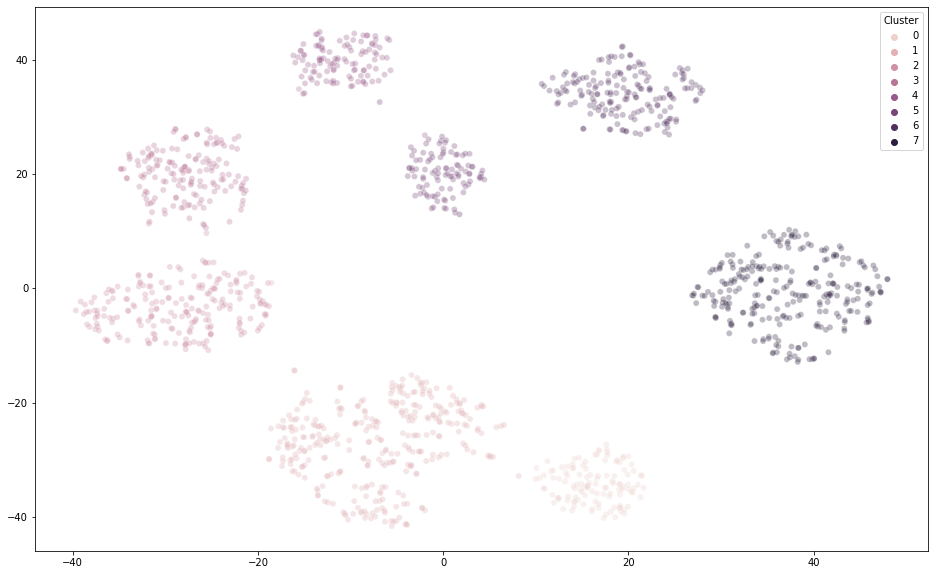

In [ ]:
# Plot kmeans clusters
import plotly.express as px
cluster = kmean_df['Cluster']

  

## Determine the best possible value of k.

There isn't a definitive set of rules to automatically extract the optimal number of K In most cases the better way of choosing the number of clusters is to ask 

> "For what purpose are we using K-means"


From there think about what is the optimal number of clusters to serve our purpose. For our problem statement, our ultimate goal is to find out "*Which group of employee is the most vulnerable for resignation*". From my human intution, I can currently only logically determin 5-10 different types of Employees that would share similar needs for each cluster. However, this 5-10 range is completely ambigious from my own intuition. 

Therefore, we would require a more systemtic method of choosing optimal number of K

### Computational Methods for choosing K

There are a few visual methods that can aid us in choosing No.K which includes:



*   Elbow Method
*   List item

Following the Elbow plot, we will be making use of of the Silhouette Clustering for to validate the number of k chosen by the elbow plot for  clustering models.


There isn't a definitive set of rules to automatically extract the optimal number of K

## Silhouette Clustering for validating clustering models

Silhouette  clustering is a method used to quantify/validate how well a clustering 

There is two components that are calculated in Silhouette clustering

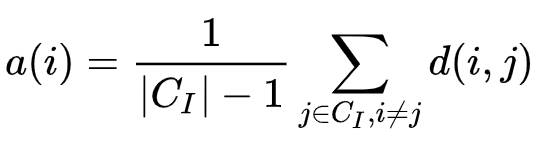

Where 
data point i in the cluster {C_{I}}C_{I}

- $a^{(i)}$ : Average Distance to other datapoints of the Assigned Cluster Centroids

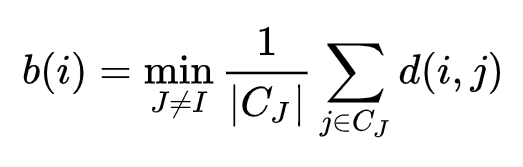

- $b^{(i)}$ : Average Distance to Nearest Cluster Centroids

If cluster model is good, **b(i) > a(i)** . 

The output from Silhouette cluster ranges from -1 to 1, the closer the silhouette score is to 1, the better the model

In [ ]:
def get_cluster_centroids(data):
    cluster_centers = data.groupby('Cluster').mean()
    cluster_centers['Cluster Size (% of Total)'] = pd.Series(data['Cluster']).value_counts() / len(data['Cluster']) * 100
    return cluster_centers

## Testing DBSCAN

## TSNE 

We will be utilizing t-Distributed Stochastic Neighbor Embedding (t-SNE) to help us visualize our high dimensinal dataset in two diemnsions to be able to plot at visualize clusters more effectively.

There are two parameterds to TSNE



1.   perplexity
2.   learning_rate

For Perplexity, the [Sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) documentation mentioned selecting a perplexity value between 5 and 50. 

We iterate through potential values 



In [ ]:
display(df_onehot)

Age  Distance  Job_Satisfaction    Salary  Work_Life_Balance  \
0     0.446350 -1.010909          1.153254 -0.108350          -2.493820   
1     1.322365 -0.147150         -0.660853 -0.291719           0.338096   
2     0.008343 -0.887515          0.246200 -0.937654           0.338096   
3    -0.429664 -0.764121          0.246200 -0.763634           0.338096   
4    -1.086676 -0.887515         -0.660853 -0.644858           0.338096   
...        ...       ...               ...       ...                ...   
1465 -0.101159  1.703764          1.153254 -0.835451           0.338096   
1466  0.227347 -0.393938         -1.567907  0.741140           0.338096   
1467 -1.086676 -0.640727         -0.660853 -0.076690           0.338096   
1468  1.322365 -0.887515         -0.660853 -0.236474          -1.077862   
1469 -0.320163 -0.147150          0.246200 -0.445978           1.754054   

      Service_Years  BusinessTravel_Travel_Frequently  \
0         -0.164613                                 0   
1          0.488508                                 1   
2         -1.144294                                 0   
3          0.161947                                 1   
4         -0.817734                                 0   
...             ...                               ...   
1465      -0.327893                                 1   
1466      -0.001333                                 0   
1467      -0.164613                                 0   
1468       0.325228                                 1   
1469      -0.491174                                 0   

      BusinessTravel_Travel_Rarely  MaritalStatus_Married  \
0                                1                      0   
1                                0                      1   
2                                1                      0   
3                                0                      1   
4                                1                      1   
...                            ...                    ...   
1465                             0                      1   
1466                             1                      1   
1467                             1                      1   
1468                             0                      1   
1469                             1                      1   

      MaritalStatus_Single  Resign Status_Yes  
0                        1                  1  
1                        0                  0  
2                        1                  1  
3                        0                  0  
4                        0                  0  
...                    ...                ...  
1465                     0                  0  
1466                     0                  0  
1467                     0                  0  
1468                     0                  0  
1469                     0                  0  

[1470 rows x 11 columns]

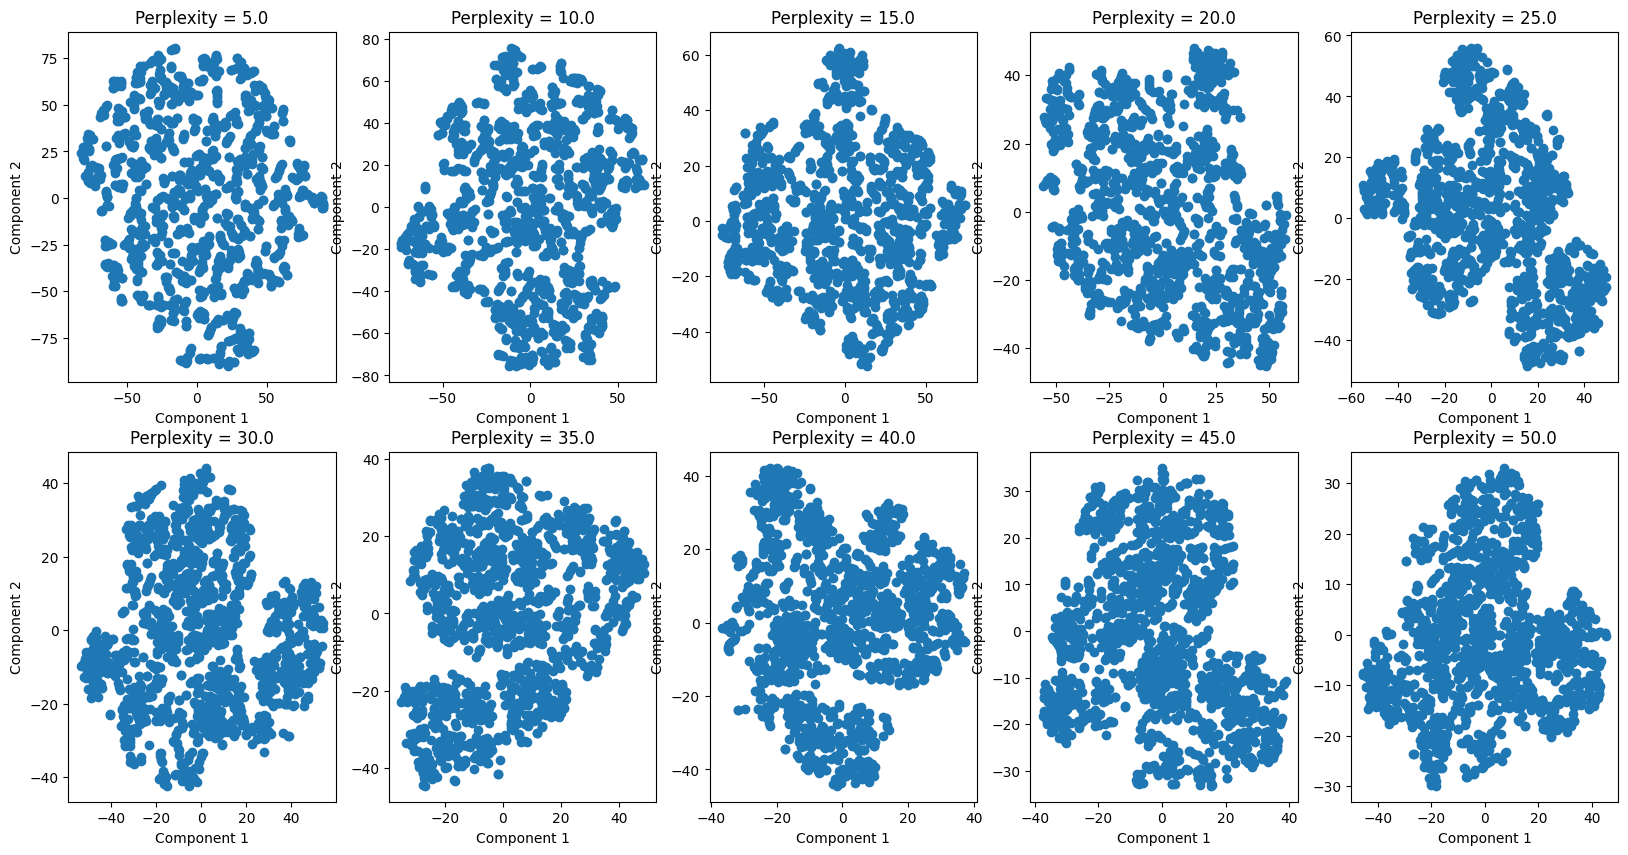

In [ ]:
tsne = TSNE()

perplexity= np.linspace(start=10,stop=500,num=10)


fig, axes = plt.subplots(2,5, figsize=(20,10))
for idx,perplexity in enumerate(perplexity):
  tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=perplexity)
  X_embedded = tsne.fit_transform(df_onehot)
  axes[idx//5,idx%5].scatter(X_embedded[:,0], X_embedded[:,1])
  axes[idx//5,idx%5].set_title('Perplexity = {}'.format(perplexity))
  axes[idx//5,idx%5].set_xlabel('Component 1')
  axes[idx//5,idx%5].set_ylabel('Component 2')

Observations:
we 

Conclusion:

We will use TSNE with perplexity = 35 as it its most interpretable

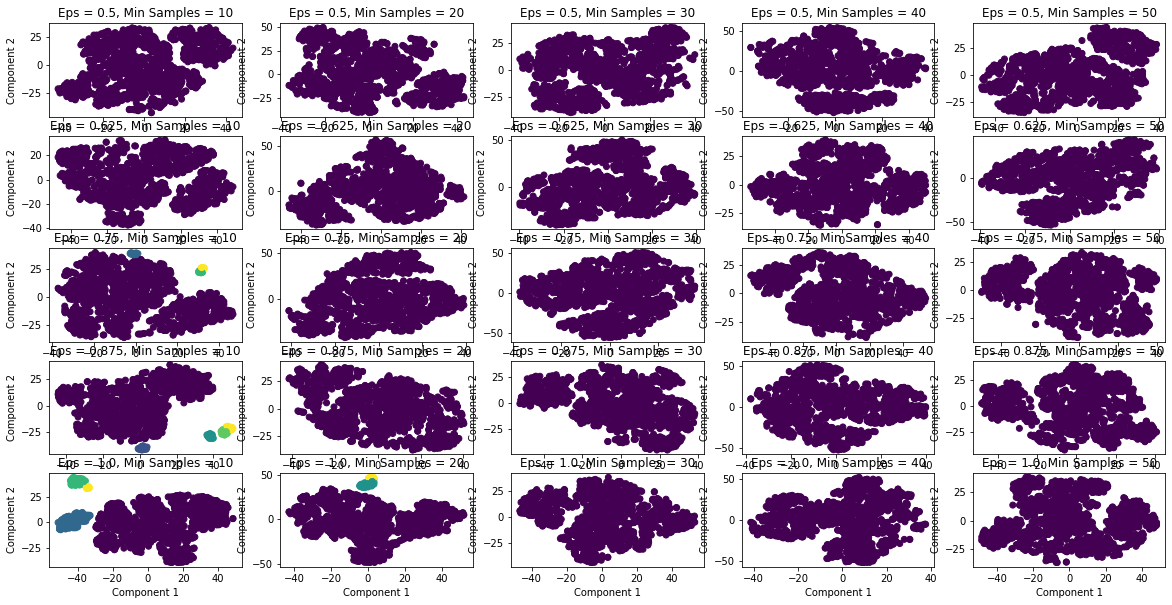

In [ ]:
epsilon = np.linspace(start=0.5,stop=1,num=5)
min_samples = np.linspace(start=10,stop=50,num=5)
# convert from float to int
min_samples = min_samples.astype(int)
dbscan_df = df_onehot.copy()

# Plot Dbscan results for different values of epsilon and min_samples
fig, axes = plt.subplots(5,5, figsize=(20,10))
for idx, eps in enumerate(epsilon):
    for idx2 , min_sample in enumerate(min_samples):
        tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=35)
        cluster_labels = DBSCAN(eps=eps, min_samples=min_sample).fit_predict(dbscan_df)
        dbscan_df['Cluster'] = cluster_labels
        X_embedded = tsne.fit_transform(dbscan_df)
        axes[idx,idx2].scatter(X_embedded[:,0], X_embedded[:,1], c=dbscan_df['Cluster'])
        axes[idx,idx2].set_title('Eps = {}, Min Samples = {}'.format(eps, min_sample))
        axes[idx,idx2].set_xlabel('Component 1')
        axes[idx,idx2].set_ylabel('Component 2')
        # add legend
        axes.legend(loc='upper right')

In [ ]:
def plot_dbscan(df,epsilon = 1,min_samples=50,plot=True):
    cluster_labels = DBSCAN(eps=eps, min_samples=min_sample).fit_predict(df)
    df['Cluster'] = cluster_labels
    # Unique values of cluster > 5
    if cluster_labels.unique().shape[0] > 5:
        display(df)
        plot = True
    cluster = df['Cluster']
    if plot:
        plot_tsne_clusters(df,cluster)
        plt.title('Eps = {}, Min Samples = {}'.format(eps, min_sample))

In [ ]:
dbscan_df = df_onehot.copy()



Age  Distance  Job_Satisfaction    Salary  Work_Life_Balance  \
0     0.446350 -1.010909          1.153254 -0.108350          -2.493820   
1     1.322365 -0.147150         -0.660853 -0.291719           0.338096   
2     0.008343 -0.887515          0.246200 -0.937654           0.338096   
3    -0.429664 -0.764121          0.246200 -0.763634           0.338096   
4    -1.086676 -0.887515         -0.660853 -0.644858           0.338096   
...        ...       ...               ...       ...                ...   
1465 -0.101159  1.703764          1.153254 -0.835451           0.338096   
1466  0.227347 -0.393938         -1.567907  0.741140           0.338096   
1467 -1.086676 -0.640727         -0.660853 -0.076690           0.338096   
1468  1.322365 -0.887515         -0.660853 -0.236474          -1.077862   
1469 -0.320163 -0.147150          0.246200 -0.445978           1.754054   

      Service_Years  BusinessTravel_Travel_Frequently  \
0         -0.164613                                 0   
1          0.488508                                 1   
2         -1.144294                                 0   
3          0.161947                                 1   
4         -0.817734                                 0   
...             ...                               ...   
1465      -0.327893                                 1   
1466      -0.001333                                 0   
1467      -0.164613                                 0   
1468       0.325228                                 1   
1469      -0.491174                                 0   

      BusinessTravel_Travel_Rarely  MaritalStatus_Married  \
0                                1                      0   
1                                0                      1   
2                                1                      0   
3                                0                      1   
4                                1                      1   
...                            ...                    ...   
1465                             0                      1   
1466                             1                      1   
1467                             1                      1   
1468                             0                      1   
1469                             1                      1   

      MaritalStatus_Single  Resign Status_Yes  Cluster  
0                        1                  1       -1  
1                        0                  0       -1  
2                        1                  1       -1  
3                        0                  0       -1  
4                        0                  0       -1  
...                    ...                ...      ...  
1465                     0                  0       -1  
1466                     0                  0       -1  
1467                     0                  0       -1  
1468                     0                  0       -1  
1469                     0                  0       -1  

[1470 rows x 12 columns]

In [ ]:
epsilon = np.linspace(start=1,stop=5,num=10)
# convert to int
min_samples = np.linspace(start=10,stop=50,num=10)
min_sample = min_samples.astype(int)

for idx,eps in enumerate(epsilon):
    for idx2, min_sample in enumerate(min_samples):
        plot_dbscan(dbscan_df,eps,min_sample)


TypeError: min_samples must be an instance of int, not float64.

# Quality of Clustering

For clustering models, there isn't a “truth” is available to verify results. Clustering being an unsupervised learning technique.

On top of performing some Visual checks that the clusters look as expected

We are going to check some commonly-used metrics in the following:



*   Cluster cardinality
    > Number of examples per cluster


*   Cluster magnitude
    > Sum of distances from all examples to the centroid of the cluster.

* Magnitude vs. Cardinality
    > Plot magnitude against cardinality to find anomalous clusters

References: [Google Developers: Interpret Results and Adjust Clustering](https://developers.google.com/machine-learning/clustering/interpret)


In [ ]:
# NEed to come out with code to graphically display the results of all this

## Model Improvement

Since we know that k means clustering is based on eldician distance, we will try to transform the following features `Distance`,`Service Years` and `Salary` to make it follow a gasiuan distribution before scaling down to [0-1] 


Log scale before standardizing?

In [44]:
df_transform  = df_raw.copy()


In [35]:
df_transform.columns

Index(['Age', 'Gender', 'BusinessTravel', 'Job Function', 'Distance',
       'Education', 'Job_Satisfaction', 'MaritalStatus', 'Salary',
       'Performance_Rating', 'Work_Life_Balance', 'Service_Years',
       'Resign Status'],
      dtype='object')

In [45]:
features_log_transform = ['Distance', 'Service_Years','Salary']
numeric_features = df_eda_num.columns
# Log transform the features
df_transform[features_log_transform] = df_raw[features_log_transform].apply(lambda x: np.log(x+1))

# Min max scaling 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df_transform[numeric_features])
df_transform_scaled = scaler.transform(df_transform[numeric_features])

display(df_transform_scaled)

array([[0.54761905, 0.        , 0.25      , ..., 0.        , 0.        ,
        0.52399957],
       [0.73809524, 0.55540972, 0.        , ..., 1.        , 0.66666667,
        0.64571125],
       [0.45238095, 0.14972585, 0.25      , ..., 0.        , 0.66666667,
        0.        ],
       ...,
       [0.21428571, 0.3383581 , 0.5       , ..., 1.        , 0.66666667,
        0.52399957],
       [0.73809524, 0.14972585, 0.5       , ..., 0.        , 0.33333333,
        0.62004589],
       [0.38095238, 0.55540972, 0.5       , ..., 0.        , 1.        ,
        0.43339348]])